# **EE 488 AI Convergence Capstone Design: Anomaly Detection**

## **HW4: Classification Task**

**Description**

This project focuses on a classification problem.

We will use fan machine data from the DCASE 2020 Task 2 dataset, a subset of the MIMII dataset.

Since the objective is to classify machine IDs rather than to detect anomalies, only the provided training data will be used.

The dataset will be constructed by splitting the original training samples into training and testing sets at a 9:1 ratio for each machine ID.

This classification task involves seven distinct classes, corresponding to machine IDs 0 through 6 of the fan machine type.

As part of the assignment, students are also expected to understand how to generate spectrograms from audio signals using the techniques discussed in class, and to implement these techniques in code.


**This assignment consists of two main objectives:**

**Problem 1.** Implement a Dataset and Train a Classifier [4 pts]

- Create a custom PyTorch `Dataset` class to load spectrogram data with the correct labels (machine IDs 0–6). Then, implement a training loop to train a neural network classifier using this dataset.

**Problem 2.** Design and Implement a Spectrogram-based Feature Extractor [6 pts]

- Develop a feature extractor capable of classifying machine IDs based on spectrogram input. The model should learn discriminative audio patterns and produce final class predictions for machine IDs 0 through 6. [4 pts]

- Achieve a classification accuracy over **at least 85%**. [2 pts]


# 0. Mounting Google Drive

**[Important!]**

Before running this code, you must download the training and test datasets for the fan category.

Both `train.zip` and `test.zip` are uploaded to KLMS.
Please download these `.zip` files and upload them to your Google Drive.

The default root path for Google Drive is `gdrive/MyDrive/`.  
If you upload the files to a different location, you will need to modify the `root_path` in the code below accordingly.


In [1]:
# from google.colab import drive
import os
# drive.mount('/content/gdrive')
root_path = '/home/hongju/EE488/hw4/'
os.chdir(root_path)

# !pip install torchinfo # install torchinfo module

In [2]:
# !unzip -qq -n train.zip
# !unzip -qq -n test.zip

# 1. Importing Packages

New libraries introduced for this project:

*   `librosa`: A Python package for music and audio analysis. (https://librosa.org/doc/latest/index.html)
    - Used to extract spectrograms from audio data.
*   `glob`: A package used for reading files by pattern matching.


In [3]:
import sys
import librosa           # use for sound data
import librosa.core
import librosa.feature
import librosa.display
import glob
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from torchinfo import summary
import IPython.display as ipd

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [5]:
import random
import os

def set_seed(seed=42):
    random.seed(seed)                         # Python random 고정
    np.random.seed(seed)                      # Numpy random 고정
    torch.manual_seed(seed)                   # PyTorch CPU 고정
    torch.cuda.manual_seed(seed)              # PyTorch GPU 1개 고정
    torch.cuda.manual_seed_all(seed)          # PyTorch GPU 여러개 고정
    os.environ['PYTHONHASHSEED'] = str(seed)   # 환경 변수 고정

    # CuDNN 관련 고정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# random seed 고정
set_seed(0)


# 2. Audio Data Preprocessing

### 2-1. Acoustic Feature: Audio Data

Let's first visualize the audio signal.

The following audio clip is from a normal fan with ID 1.


In [6]:
file_dir= './data/train/normal_id_01_00000000.wav'
#========================================#
y, sr = librosa.load(file_dir, sr = None)
#========================================#

print(f'shape of signal is :{y.shape}')
print(f'signal is {y}')
print(f'sampling rate is {sr}hz')

shape of signal is :(160000,)
signal is [ 0.00753784  0.00976562  0.00485229 ... -0.00299072 -0.00473022
  0.00015259]
sampling rate is 16000hz


### 2-2. Acoustic Feature: Spectrogram

While some deep learning models directly use audio signals as input, many models rely on two-dimensional data representations.

To convert audio signals into two-dimensional data, we generate spectrograms.

Apply the **Short-Time Fourier Transform (STFT)** to `y`. Use a Hann window with the specified hop length and FFT size (`n_fft`) as defined below.

You can use the `stft` function from the `librosa` module.

Follow these steps:

1. Compute the absolute value of the STFT output.
2. Convert the amplitude spectrogram to the decibel (dB) scale using `amplitude_to_db` from `librosa`, setting the reference to `np.max`.

Setting `ref=np.max` maps the maximum value of the input matrix to 0 dB.

For details, refer to:
http://librosa.org/doc/main/generated/librosa.stft.html


In [7]:
hop_length = 512
n_fft = 2048

#=====================================================================#
Y = librosa.stft(y, window='hann', n_fft=n_fft, hop_length=hop_length)
D = librosa.amplitude_to_db(np.abs(Y), ref=np.max)
#=====================================================================#

In [8]:
print(D.shape)

(1025, 313)


Text(0.5, 1.0, './train/normal_id_01_00000000.wav')

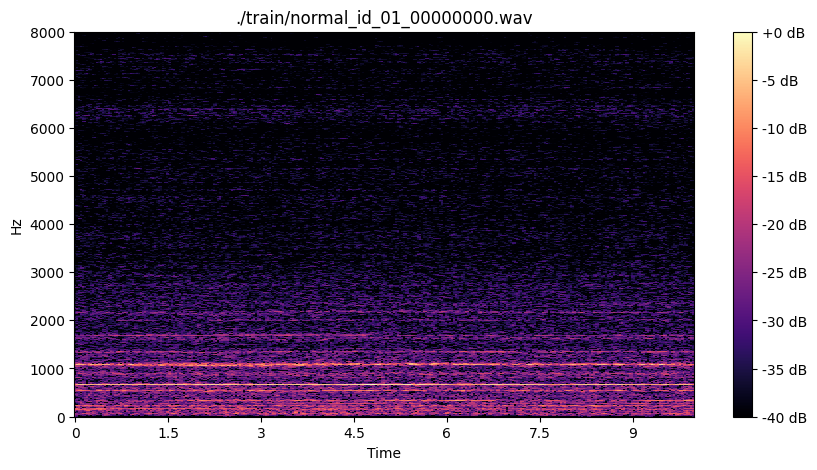

In [9]:
plt.figure(figsize=(10, 5))
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', vmin=-40, vmax=0, hop_length=hop_length, sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('./train/normal_id_01_00000000.wav')

### **[Problem 1-1]**

### 2-3. Feature Extraction Function

Now, let's create a function to extract spectrogram features from raw audio.

Write a function called `extract_feature` that:

- Takes a path as input.
- Loads the audio from the path using `librosa.load()` with `sr=16000`.
- Computes the spectrogram following the steps explained above.
- Normalizes the spectrogram.

*Important:* To prevent memory issues when training on Google Colab, reduce the number of frames if the audio is too long.  
(You will be penalized if you omit this part.)


In [10]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

### 2-4. Checking Feature Extraction

Apply the `extract_feature` function to a few sample data points and visualize the results.

Check whether the spectrograms are generated correctly.


Sample features shape: (5, 13)
Sample labels: ['normal', 'normal', 'normal', 'normal', 'normal']


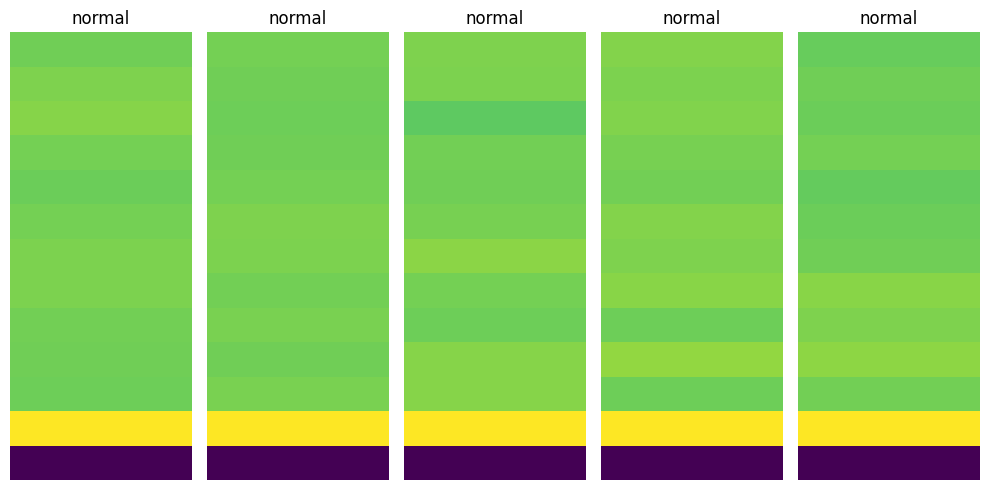

In [11]:
# apply extract_features to a few sample data points and visualize the results
sample_files = glob.glob('./data/train/*.wav')[:5]
sample_features = [extract_features(file) for file in sample_files]
sample_labels = [os.path.basename(file).split('_')[0] for file in sample_files]
print("Sample features shape:", np.array(sample_features).shape)
print("Sample labels:", sample_labels)
plt.figure(figsize=(10, 5))
for i, (features, label) in enumerate(zip(sample_features, sample_labels)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(features.reshape(13, 1), aspect='auto', origin='lower')
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

### **[Problem 1-2]**
# 3. Dataset Construction 

Next, we will build the dataset.


In [12]:
# Dataset path setting
train_dir = './data/train'         # train dataset dir
test_dir = './data/test'             # test dataset dir
model_dir = './model'                 # saving model dir

# Parameters for mel-spectrogram
n_fft = 2048                          # window size for stft
hop_length = 512                      # number of samples for window moving
n_mels = 128                          # number of frequency bin
power = 2                             # spectrogram power
frames = 5                            # number of time frames for model's input

# Training parameters
EPOCHS = 25                           # training epochs
BATCH = 1024                          # mini-batch size

In [13]:
os.makedirs(model_dir, exist_ok=True)

train_dir = os.path.abspath(train_dir)

files = glob.glob(os.path.join(train_dir, '*.wav'))
train_data = files

### 3-1. Data Labeling

You will use fan ID labels 0 to 6 as class labels.

Map each ID to a corresponding label index.


In [14]:
label_list = range(0, 7)
train_label = [int(file.split("_")[-2]) for file in train_data if int(file.split("_")[-2]) in label_list]
print(len(train_data), len(train_label))

5865 5865


### 3-2. Dataset Class

Create a custom `Dataset` class using PyTorch.

The class should:

- Accept a list of file paths and corresponding labels.
- Load the spectrogram feature for each sample in `__getitem__()`.


In [15]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, label, n_fft=2048, hop_length=512, n_mels=128, power=2, frames=5):
        self.data = data
        self.label = label
        
        # Parameters for mel-spectrogram
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.power = power
        self.frames = frames

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file = self.data[idx]
        y, sr = librosa.load(file, sr=None)
        
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels, power=self.power)
        # mel = librosa.power_to_db(mel, ref=np.max)
        return np.array([mel]), self.label[idx]

train_dataset = CustomDataset(train_data, train_label, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power, frames=frames)
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

### 3-3. Split Dataset

Split the dataset into training and validation sets.

Use a ratio of 9:1 (90% training, 10% validation) for each machine ID.


In [16]:
# split the dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)

In [17]:
# check the shape of the data
for mel, label in train_dataloader:
    print(f"Shape of mel: {mel.shape}")
    print(f"Shape of label: {label.shape}")
    break

Shape of mel: torch.Size([1024, 1, 128, 313])
Shape of label: torch.Size([1024])


 ### **[Problem 2]**
 # 4. Model Construction

Now, you will design and implement the model.


### 4-1. Feature Extractor Design

Design a feature extractor based on a convolutional neural network (CNN).

The network should take a spectrogram as input and output class logits corresponding to machine IDs 0 through 6.

You may refer to examples discussed in class.


### 4-2. Classifier Construction

After the feature extractor, add a fully connected layer (linear classifier) to map the extracted features to the 7 class outputs.


In [18]:
class Model(nn.Module):
    def __init__(self, n_mels=128, n_classes=10):
        super(Model, self).__init__()
        self.n_classes = n_classes
        self.feature_extrator = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.features = nn.Sequential(
            nn.Linear(79872, 512),
        )
        self.fc = nn.Sequential(
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        # x: [B, 1, F, T]  # log-mel spec
        features = self.feature_extrator(x)
        features = features.reshape(features.size(0), -1)
        features = self.features(features)
        logits = self.fc(features) 
        return features, logits 

In [19]:
model = Model(n_mels=128, n_classes=len(label_list))
summary(model, input_size=(BATCH, 1, n_mels, 313))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1024, 512]               --
├─Sequential: 1-1                        [1024, 128, 16, 39]       --
│    └─Conv2d: 2-1                       [1024, 32, 64, 156]       160
│    └─BatchNorm2d: 2-2                  [1024, 32, 64, 156]       64
│    └─ReLU: 2-3                         [1024, 32, 64, 156]       --
│    └─Conv2d: 2-4                       [1024, 64, 32, 78]        8,256
│    └─BatchNorm2d: 2-5                  [1024, 64, 32, 78]        128
│    └─ReLU: 2-6                         [1024, 64, 32, 78]        --
│    └─Conv2d: 2-7                       [1024, 128, 16, 39]       32,896
│    └─BatchNorm2d: 2-8                  [1024, 128, 16, 39]       256
│    └─ReLU: 2-9                         [1024, 128, 16, 39]       --
├─Sequential: 1-2                        [1024, 512]               --
│    └─Linear: 2-10                      [1024, 512]               40,894,9

### **[Probelm 1-3]**
# 5. Training the Model

Now, you will train the model.


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 5-1. Training Loop

Implement a training loop that:

- Trains the model using the training set.
- Evaluates the model using the validation set after each epoch.
- Tracks and plots the training and validation losses.


In [21]:
import torch.nn.functional as F

def train(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  losses = []
  y_true_all = []
  y_pred_all = []
  
  for batch, (X, y) in enumerate(dataloader):

    ####### Fill in the blanks
    _, logits = model(X.to(device))
    p = F.one_hot(y, num_classes=7).float().to(device)
    
    loss = loss_fn(logits, p)
    losses.append(loss.cpu().detach())
    
    pred_label = torch.argmax(logits, dim=1).cpu()
    y = torch.argmax(p, dim=1).cpu()

    # 저장
    y_true_all.extend(y.cpu())
    y_pred_all.extend(pred_label.cpu())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 30 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>5f}  [{current:>5d}/{size:>5d}]")
  
  y_true_all = np.array(y_true_all)
  y_pred_all = np.array(y_pred_all)
  
  acc = metrics.accuracy_score(y_true_all, y_pred_all)
  
  return np.mean(losses), acc

In [22]:
def validate(val_loader, model, loss_fn):
    model.eval()
    losses = []
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for X, y in val_loader:
            _, logits = model(X.to(device))
            p = F.one_hot(y, num_classes=7).float().to(device)
            loss = loss_fn(logits, p)
            losses.append(loss.cpu().detach())
            pred_label = torch.argmax(logits, dim=1).cpu()
            y = torch.argmax(p, dim=1).cpu()
            y_true_all.extend(y.cpu())
            y_pred_all.extend(pred_label.cpu())
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    acc = metrics.accuracy_score(y_true_all, y_pred_all)
    return np.mean(losses), acc

In [23]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for t in range(EPOCHS):
  print(f"Epoch {t + 1}\n-------------------------------")
  
  train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
  val_loss, val_acc = validate(val_dataloader, model, loss_fn)
  
  print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}\n, Validation Accuracy: {val_acc:.4f}")
  
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

Epoch 1
-------------------------------
loss: 1.936026  [    0/ 5278]
Train Loss: 26.7974, Train Accuracy: 0.2577, Validation Loss: 5.1163
, Validation Accuracy: 0.1516
Epoch 2
-------------------------------
loss: 23.098267  [    0/ 5278]
Train Loss: 13.0167, Train Accuracy: 0.4344, Validation Loss: 5.1261
, Validation Accuracy: 0.2061
Epoch 3
-------------------------------
loss: 4.655213  [    0/ 5278]
Train Loss: 3.9729, Train Accuracy: 0.6578, Validation Loss: 12.0755
, Validation Accuracy: 0.1499
Epoch 4
-------------------------------
loss: 1.829282  [    0/ 5278]
Train Loss: 1.8008, Train Accuracy: 0.8441, Validation Loss: 20.4676
, Validation Accuracy: 0.1482
Epoch 5
-------------------------------
loss: 0.861663  [    0/ 5278]
Train Loss: 0.8893, Train Accuracy: 0.8829, Validation Loss: 25.9531
, Validation Accuracy: 0.1482
Epoch 6
-------------------------------
loss: 0.306035  [    0/ 5278]
Train Loss: 0.4432, Train Accuracy: 0.9451, Validation Loss: 23.3161
, Validation Ac

### 5-2. Accuracy Computation

In addition to loss, compute and track classification accuracy.

Plot both the loss and accuracy curves during training.


In [24]:
# plot both the loss and accuracy curves
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

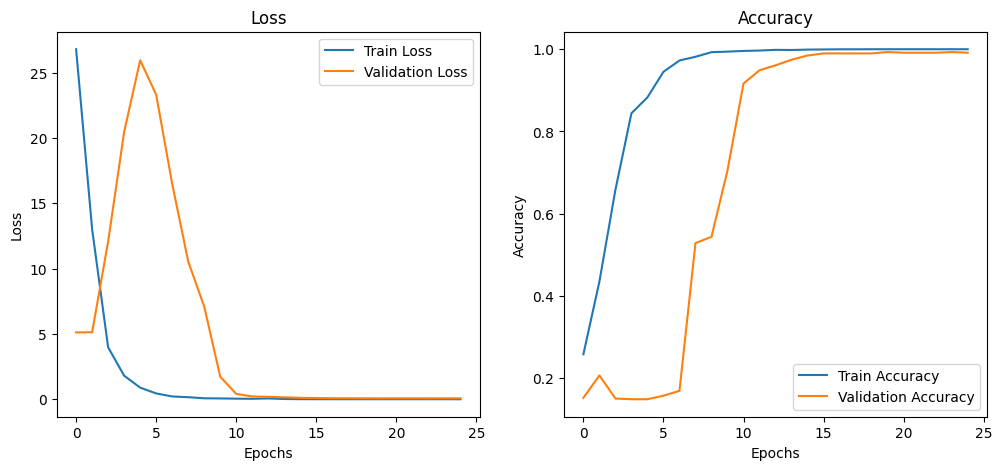

In [25]:
plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs)

### 5-3. Save the Model

After achieving at least 85% validation accuracy, save the trained model.

To save a model, use the `torch.save` function.

There are two options: saving the entire model or saving only the model's state_dict.

Since saving the state_dict is more flexible and avoids version compatibility issues, it is the recommended approach.

Use `model.state_dict()` and save it as a `.pth` file.

For details, refer to: https://pytorch.org/docs/stable/generated/torch.save.html#torch.save

In [26]:
# save the model
torch.save(model.state_dict(), os.path.join(model_dir, 'model.pth'))
# load the model
model = Model(n_mels=128, n_classes=len(label_list))
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pth')))

/tmp/ipykernel_2375804/3932883247.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pth')))


<All keys matched successfully>

# 6. Test the Model

Use the provided test set to evaluate the final performance of your model.


### **[Probelm 1-4]**
### 6-1. Load Test Files

Prepare the test data.

You need to extract features for the test files using the same feature extraction method.


In [27]:
test_dir = os.path.abspath(test_dir)

files = glob.glob(os.path.join(test_dir, '*.wav'))
test_data = files


In [28]:
test_label = [int(file.split("_")[-2]) for file in test_data if int(file.split("_")[-2]) in label_list]

test_dataset = CustomDataset(test_data, test_label, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power, frames=frames)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

### 6-2. Test Prediction

Use the trained model to predict labels for the test set.

Submit your predicted labels as a `.csv` file.


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test(dataloader, model, loss_fn):
    y_true_all = []
    y_pred_all = []
    features_all = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        p = F.one_hot(y, num_classes=7).float()
        features, pred = model(X)
        loss = loss_fn(pred, p)

        pred_label = torch.argmax(pred, dim=1).cpu()
        y = torch.argmax(p, dim=1).cpu()

        # 저장
        y_true_all.extend(y.cpu())
        y_pred_all.extend(pred_label.cpu())
        features_all.extend(features.detach().cpu())

    # numpy array로 변환
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    features_all = np.array(features_all)

    print(y_true_all.shape)
    print(y_pred_all.shape)
    print(features_all.shape)

    # 성능 지표 출력
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    rec = recall_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return y_true_all, y_pred_all, features_all

In [32]:
y_true_all, y_pred_all, features_all = test(test_dataloader, model, loss_fn)

(656,)
(656,)
(656, 512)
Accuracy: 0.9863
Precision: 0.9866
Recall: 0.9863
F1 Score: 0.9864


In [34]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 61.0 MB/s eta 0:00:0000:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


In [35]:
# save to csv file
import pandas as pd

df = pd.DataFrame({'y_true': y_true_all, 'y_pred': y_pred_all})
df.to_csv('submission.csv', index=False)

Visualize the confusion matrix.

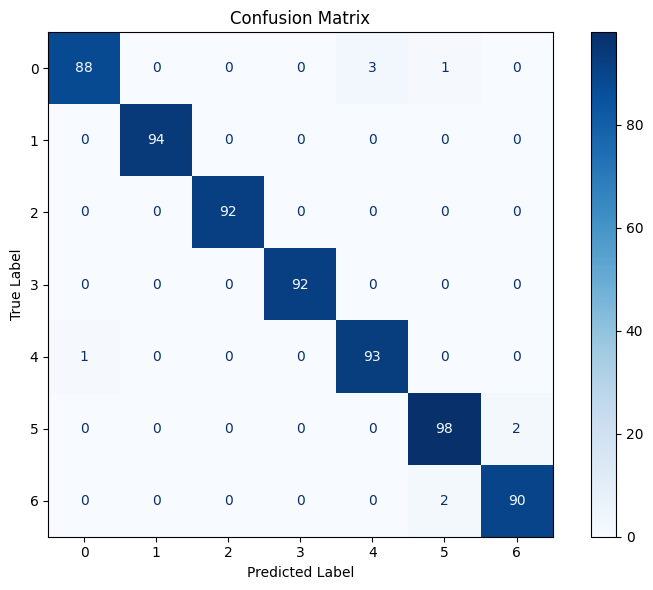

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_true_all, y_pred_all)

# 클래스 이름 설정 (예: 0 ~ 9)
class_names = [str(i) for i in range(cm.shape[0])]

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# 7. Submission

Please submit the following files:

- A `.ipynb` file containing your full code and results (including plots).
- A `.csv` file containing your test predictions.
- A `.pth` file containing your trained model.


# Notes

- Your spectrograms should be generated from the **raw waveform** during runtime (i.e., not precomputed and saved).
- Do not hardcode labels. They must be assigned dynamically based on the file path.
- Normalize your features for stable training.
- If your validation accuracy is below 85%, you will receive partial credit.
- If the accuracy is abnormally low (e.g., 20–30%), it will be considered a serious error.


# Appendix

You may optionally modify the spectrogram parameters (e.g., window size, hop length) to optimize performance.

However, do not modify the dataset construction rules.


### Tip: Improving Performance

You can try the following strategies:

- Tune spectrogram parameters (window size, hop length, etc.).
- Add data augmentation techniques.
- Try different model architectures.
- Adjust the learning rate, batch size, and optimizer.


### Tip: Troubleshooting

Common problems include:

- Feature extraction errors.
- Data leakage between training and validation sets.
- Incorrect label assignment.
- Overfitting to the training data.


# Good Luck! 🎯

If you have any questions, feel free to ask during class or through the Q&A board.


# End of Homework 4

t-SNE (t-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique used to visualize high-dimensional data in 2D or 3D space.

It helps you see the structure of your data (e.g., clusters, separations) by preserving local relationships.

It is mainly used for visualization, not for further model training.

It shows how similar or different the samples are in the feature space.

<br>

**To apply t-SNE, you need:**

✅ High-dimensional feature vectors (embeddings)

✅ Corresponding labels (optional, for coloring different classes)

<br>

**Important:**

The input should be meaningful feature representations, such as embeddings or latent features.

Raw logits (i.e., model output scores before softmax) are usually not suitable by themselves,
because logits mainly represent class scores, not the full structure of the data.



In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, n_classes):
    print(features.shape)
    labels = torch.Tensor(labels)
    tsne = TSNE(n_components=2, random_state=0)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(10,8))
    for i in range(n_classes):
        plt.scatter(reduced[labels==i, 0], reduced[labels==i, 1], label=f'Class {i}', alpha=0.5)
    plt.legend()
    plt.title('t-SNE of Feature Representations')
    plt.show()


(656, 512)


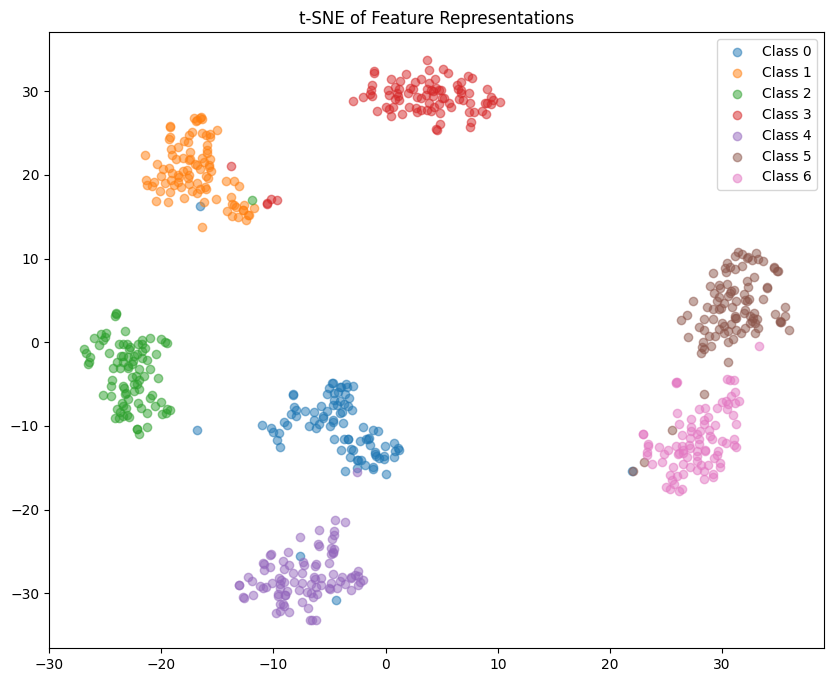

In [37]:
plot_tsne(features_all, y_true_all, len(label_list))